# Galaxy classification
This is a ML code that performs galaxy classification using user-defined labels from the Galaxy-Zoo (http://zoo1.galaxyzoo.org/) project. 

The steps are the following: <br>
1. Import libraries and sample
2. Split sub-samples (training, validation, testing)
3. Fit with various classifier and check performance
4. Compare various classifiers in testing sample

In [10]:
# Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import LabelEncoder

# from sklearn import datasets, utils, metrics
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import RandomForestClassifier

# import warnings
# warnings.simplefilter('ignore')

In [2]:
path_to_data = "../data/GALFIT_v3/"

In [3]:
# Here we are going to use astropy to read fits images and convert them into 
# similar format matrices
# you can also use np.matrix.flatten to flatten a matrix into a single line
import glob
files = glob.glob(path_to_data + "/*.npy")

# remove:files = files[0:100]

galaxies = np.array([np.load(i) for i in files])
labels = [file.split("/")[-1].split("_")[0] for file in files]

# Display some example images of galaxies
images_and_labels = list(zip(galaxies, labels))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(galaxies)
print(galaxies.shape)
# data = galaxies.reshape((n_samples, -1))

# Normalize values to maximum (and setting low values to 0)
for i in range(len(galaxies)):
    galaxies[i] = galaxies[i] / np.max(galaxies[i])


# Shuffle the samples
shuffled_indexes = np.arange(len(galaxies))
np.random.shuffle(shuffled_indexes)

galaxies = galaxies[shuffled_indexes]
labels = np.array(labels)[shuffled_indexes]

# Convert labels to integers
tmp = np.zeros(len(labels))
tmp[labels == 'ellipt'] = 1
labels = tmp


print(labels.shape)

(10000, 128, 128)
(10000,)


In [4]:
galaxies = np.expand_dims(galaxies, axis=3)
labels = np.expand_dims(labels, axis=1)
print(galaxies.shape)
print(labels.shape)

(10000, 128, 128, 1)
(10000, 1)


In [5]:
# Splitting in training, validation, and test samples
data_train = galaxies[:8 * n_samples // 10] # i.e. 80% training
labels_train = labels[:8 * n_samples // 10]

data_valid = galaxies[8 * n_samples // 10:9 * n_samples // 10] # i.e. 10% validation (80->90%)
labels_valid = labels[8 * n_samples // 10:9 * n_samples // 10]

data_test = galaxies[9 * n_samples // 10:] # i.e. 10% testing (90->100%)
labels_test = labels[9 * n_samples // 10:]


### Check labels

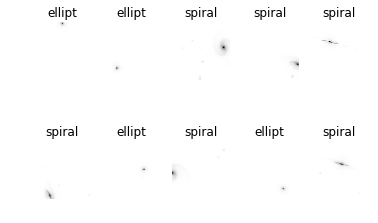

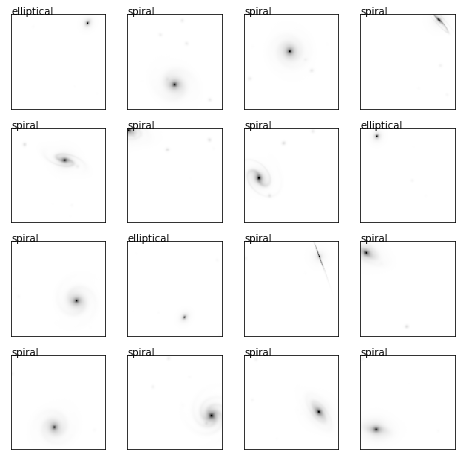

In [6]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(data_train[i,:,:,0], cmap=plt.cm.binary)
#     plot_image(i, predictions, labels_train, data_train)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    if labels_train[i,0] == 0:
        label = 'spiral'
    else:
        label = 'elliptical'
        
    plt.text(0, 0, label)
    
plt.show()

### Let's give this shit a try

### Simple model with a single hidden layer

In [13]:
model = keras.Sequential([keras.layers.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same',
                                              activation=tf.nn.relu, input_shape=(128,128,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation=tf.nn.relu),
                          keras.layers.Dense(2, activation=tf.nn.softmax)
                          ])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(data_train, labels_train, validation_data=(data_valid, labels_valid), 
                                            epochs=2, batch_size=10, verbose=2)

predicted = model.predict(data_valid)

Train on 8000 samples, validate on 1000 samples
Epoch 1/2
 - 193s - loss: 0.1258 - acc: 0.9489 - val_loss: 0.0542 - val_acc: 0.9780
Epoch 2/2
 - 204s - loss: 0.0253 - acc: 0.9926 - val_loss: 0.0634 - val_acc: 0.9800


In [14]:
test_loss, test_acc = model.evaluate(data_test, labels_test)

print('Test accuracy:', test_acc)

1000/1000 [==============================] - 4s 4ms/step

### Let's add an additional hidden convolutional layer

In [19]:
model = keras.Sequential([keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same',
                                              activation=tf.nn.relu, input_shape=(128,128,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2)),                        
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation=tf.nn.relu),
                          keras.layers.Dense(10, activation=tf.nn.softmax)
                          ])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train, labels_train, epochs=5)

Epoch 1/5
8000/8000 [==============================] - 165s 21ms/step - loss: 0.2736 - acc: 0.8700

In [ ]:
test_loss, test_acc = model.evaluate(data_test, labels_test)

print('Test accuracy:', test_acc)

1000/1000 [==============================] - 6s 6ms/step

### Now, let's add dropout

In [ ]:
model = keras.Sequential([keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same',
                                              activation=tf.nn.relu, input_shape=(128,128,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1)),
                          keras.layers.MaxPool2D(pool_size=(2,2)),                        
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation=tf.nn.relu),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(10, activation=tf.nn.softmax)
                          ])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train, labels_train, epochs=5)

Epoch 1/5
8000/8000 [==============================] - 166s 21ms/step - loss: 0.2480 - acc: 0.8859

In [ ]:
test_loss, test_acc = model.evaluate(data_test, labels_test)

print('Test accuracy:', test_acc)